# Calibrating ensemble models with Logistic Regression

### Logistic regression for calibrating binary classification models (or Platt scaling)

Assuming that we know the predictions of an ensemble model trained to predict a binary variable *True_Label={0,1}*, we can train a Logistic Regression to predict the same initial binary variable *True_Label={0,1}* using the predictions of the base model as unique feature. Then, the predictions of the second model will be the calibrated predictions of our initial model.

*Note:* The model is explained in the paper *Handmade_Logistic_Regression.pdf* from the repository *Coding-Machine-Learning-algorithms-from-scratch-in-R* .

\begin{equation} P(1|Prediction) = sigmoid(z) = \frac{1}{1+e^{-z}}=\frac{1}{1+e^{-(w_0+w_1*Prediction)}} \end{equation}

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

### Import the ensemble model predictions

Import the *predictions* of the ensemble model and the *true label* (binary in this example) for each observation in a *validation* dataset, not used for training the model.

In [2]:
data = pd.read_excel('Ensemble model predictions in validation dataset.xlsx')
prediction = data["Prediction"]
true_label = data["True_Label"]
data.head()

,True_Label,Prediction
0,0,0.004622
1,0,0.261871
2,1,0.025343
3,0,0.194241
4,0,0.007017


The prediction range of the ensemble model is [0,1] equivalent to theoretical the range of probability for the event *True_Label=1*. Although, the model is not calibrated as we will see in the following plot because, for example, the bin with highest predicted values has not a 100% of positive *True_Label*. 

In [3]:
min(prediction),max(prediction)

(2.0520697034953628e-06, 0.9992258548736572)

### Calibrated predictions

Train the Logistic Regression model with the *predictions* of the ensemble model and the *true label* (binary in this example) for each observation in a *validation* dataset.

In [4]:
x_train = np.reshape(np.array(prediction),(-1,1))
y_train = np.array(true_label)
calibration_model = LogisticRegression()
calibration_model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Now compute the calibrated predictions.

In [5]:
calibrated_prediction = calibration_model.predict_proba(x_train)[:,1]
min(calibrated_prediction),max(calibrated_prediction)

(0.15920786410297164, 0.7915818845585993)

### AUC

In [6]:
from sklearn.metrics import roc_auc_score
roc_auc_score(true_label,prediction),roc_auc_score(true_label,calibrated_prediction)

(0.7319144435547351, 0.7319144435547351)

### LogLoss

In [7]:
def LogLoss(true_label,prediction):
    return(sum(true_label*np.log(prediction)+(1-true_label)*(1-np.log(prediction)))/prediction.shape[0])
LogLoss(true_label,prediction),LogLoss(true_label,calibrated_prediction)

(3.4399126426896443, 1.712502092970489)

### Bins

For binning the prediction in groups, compute the bins as evenly spaced samples calculated over the range of the predictions. You can see that the first and sample correspond to the minimum and maximum predicted values.

In [8]:
bins = np.linspace(0,1,11)

### % of True_Label=1 by binning predictions

In [9]:
binned_prediction = np.array([])
for i in range(0,bins.shape[0]-1):
    binned_prediction=np.append(binned_prediction,np.mean(true_label[(prediction<=bins[i+1])&(prediction>bins[i])]))

### % of True_Label=1 by binning calibrated predictions

In [10]:
calibrated_binned_prediction = np.array([])
for i in range(0,bins.shape[0]-1):
    calibrated_binned_prediction=np.append(calibrated_binned_prediction,np.mean(true_label[(calibrated_prediction<=bins[i+1])&(calibrated_prediction>bins[i])]))

### Mean of predictions by bins

In [11]:
binned_mean_prediction = np.array([])
for i in range(0,bins.shape[0]-1):
    binned_mean_prediction=np.append(binned_mean_prediction,np.mean(prediction[(prediction<=bins[i+1])&(prediction>bins[i])]))

### Mean of calibrated predictions by bins

In [12]:
calibrated_binned_mean_prediction = np.array([])
for i in range(0,bins.shape[0]-1):
    calibrated_binned_mean_prediction=np.append(calibrated_binned_mean_prediction,np.mean(calibrated_prediction[(calibrated_prediction<=bins[i+1])&(calibrated_prediction>bins[i])]))

### Let's plot the reliability distributions

In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

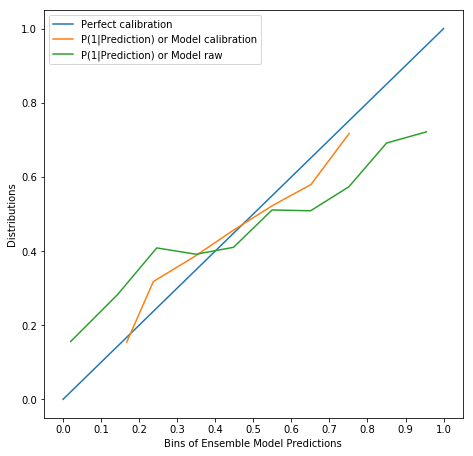

In [14]:
plt.figure(figsize=(7.5,7.5))
plt.plot([0,1],[0,1],label="Perfect calibration")
plt.plot(calibrated_binned_mean_prediction,calibrated_binned_prediction,label='P(1|Prediction) or Model calibration')
plt.plot(binned_mean_prediction,binned_prediction,label='P(1|Prediction) or Model raw')
plt.xticks(bins)
plt.xlabel("Bins of Ensemble Model Predictions")
plt.ylabel("Distributions")
plt.legend(loc='upper left')